1. stack - CSV
or by API
    yfinance - specify version

2. log-return
3. vol - stder, moving vol
    EWMA - initial sigma = stdev(first 20/60/120 days) - does it have any impact?

    How to predict vol for option for one period?

4. GARCH - use stats or implement own

 - I approach: train/test
 - II approach: rolling, fit and predict for the next day

 ACF/PACF
 tests ... Arma_garch

5. plot

6. annualization sqrt(252)  or sqrt(12)

7. implied vol -> data? historical? few days?

future volatility (depend ont expiring date)
optim prices -> caclulate implied vol numerically
8. which one to choose?

OBJECTIVES TO SELECT THE MODEL
- 




In [45]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import yfinance as yf
from arch import arch_model

### Data Preparation

In [5]:
start_date = "2023-01-01"
end_date = "2024-12-31"

In [20]:
kgh_stock = yf.Ticker('KGH.WA') #we have chosen KGHM assetss
h_data = kgh_stock.history(start=start_date, end=end_date, interval="1d")
h_data = h_data[['Close']]

h_data["Returns"] = h_data["Close"]/h_data["Close"].shift(1)
h_data["Log_returns"] = np.log(h_data["Returns"])

In [21]:
h_data

,Close,Returns,Log_returns
Date,,,
2023-01-02 00:00:00+01:00,124.085007,NaN,NaN
2023-01-03 00:00:00+01:00,126.855408,1.022327,0.022081
2023-01-04 00:00:00+01:00,128.799545,1.015326,0.015209
2023-01-05 00:00:00+01:00,132.687851,1.030189,0.029742
2023-01-09 00:00:00+01:00,143.963898,1.084982,0.081563
...,...,...,...
2024-12-19 00:00:00+01:00,117.400002,0.969847,-0.030617
2024-12-20 00:00:00+01:00,116.449997,0.991908,-0.008125
2024-12-23 00:00:00+01:00,117.300003,1.007299,0.007273


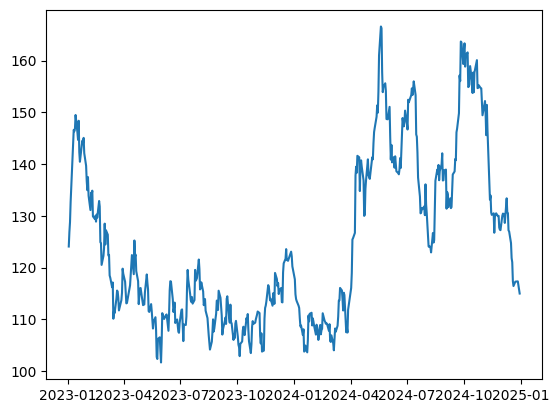

In [24]:
# plt.plot(h_data['Log_returns'])
plt.plot(h_data['Close'])

### Volatility Calculations

In [46]:
# historical volatility 
h_data['historical_volatility_30'] = h_data['Log_returns'].rolling(window=30).std()
h_data['historical_volatility_60'] = h_data['Log_returns'].rolling(window=60).std()
# * (252**0.5) - to annualize

h_data['h_vol_30_ann'] = h_data['historical_volatility_30']* np.sqrt(252)
h_data['h_vol_60_ann'] = h_data['historical_volatility_60']* np.sqrt(252)

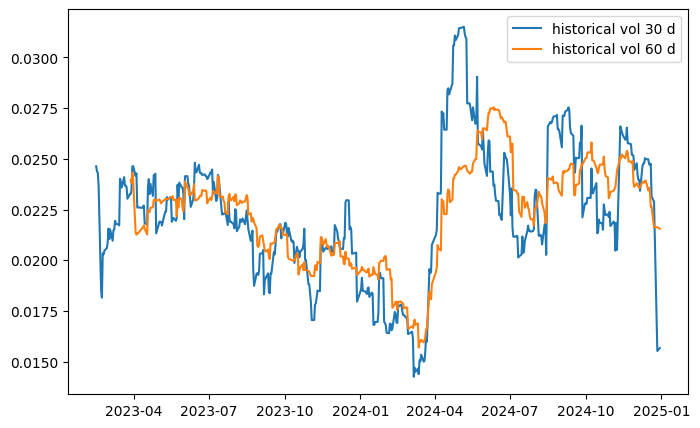

In [49]:
plt.figure(figsize=(8,5))
plt.plot(h_data['historical_volatility_30'], label = 'historical vol 30 d')
# plt.plot(h_data['h_vol_30_ann'], label = 'historical vol 30 d - ann')
plt.plot(h_data['historical_volatility_60'], label = 'historical vol 60 d')
plt.legend()

In [39]:
#EWMA volatility
def ewma_variance(returns, decay_factor):
    weights = (1 - decay_factor) * (decay_factor ** np.arange(len(returns) - 1, -1, -1))
    ewma_variance = np.sum(weights * returns**2)
    return ewma_variance

In [50]:
decay_factor = 0.94 #lambda
h_data['EWMA_variance_30'] = h_data['Log_returns'].rolling(window=30).apply(lambda x: ewma_variance(x, decay_factor), raw=True)
h_data['EWMA_volatility_30'] = np.sqrt(h_data['EWMA_variance_30'])

h_data['EWMA_variance_60'] = h_data['Log_returns'].rolling(window=60).apply(lambda x: ewma_variance(x, decay_factor), raw=True)
h_data['EWMA_volatility_60'] = np.sqrt(h_data['EWMA_variance_60'])

h_data['EWMA_vol_30_ann'] = h_data['EWMA_volatility_30']*np.sqrt(252)
h_data['EWMA_vol_60_ann'] = h_data['EWMA_volatility_60']*np.sqrt(252)

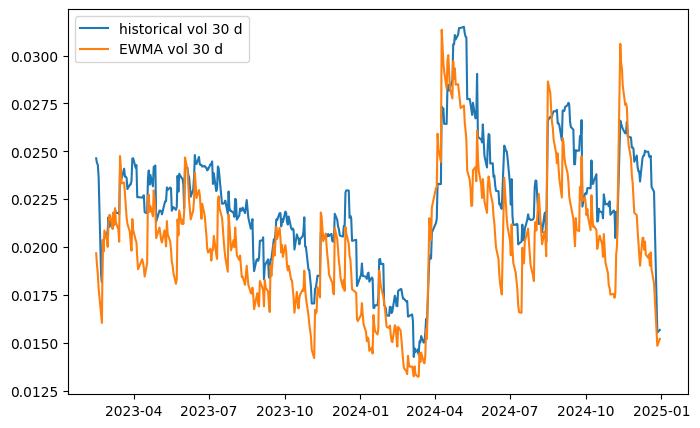

In [43]:
plt.figure(figsize=(8,5))
plt.plot(h_data['historical_volatility_30'], label = 'historical vol 30 d')
# plt.plot(h_data['historical_volatility_60'], label = 'historical vol 60 d')

plt.plot(h_data['EWMA_volatility_30'], label = 'EWMA vol 30 d')
# plt.plot(h_data['EWMA_volatility_60'], label = 'EWMA vol 60 d')

plt.legend()

In [ ]:
# GARCH volatility
